#### Combine right and left hemispheres in mega matrix to rule them all

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.font_manager

In [2]:
import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

In [3]:
from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [4]:
## Set plotting params
sns.set(rc={
             'axes.axisbelow': False,
             'axes.edgecolor': 'lightgrey',
             'axes.facecolor': 'None',
             'axes.grid': False,
             'axes.spines.right': False,
             'axes.spines.top': False,
             'figure.facecolor': 'white',
             'patch.edgecolor': 'w',
             'xtick.bottom': False,
             'xtick.direction': 'out',
             'xtick.top': False,
             'ytick.direction': 'out',
             'ytick.left': False,
             'ytick.right': False,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16})

In [5]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = .2

hemis = ['lh', 'rh']

In [6]:
both_flat_rsm = []

for hidx, hemi in enumerate(hemis):
    
    flat_rsm = make_flat_rsms(subjid, ROI_names, hemi, thresh)
    
    both_flat_rsm.append(flat_rsm)    

In [7]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [14]:
total_combs = len(subjid) * (len(ROI_names)-1) * len(hemis)
total_combs/2

56.0

In [13]:
both_flat_rsm[0].shape

(8, 7, 132355, 3)

In [10]:
total_combs = len(subjid) * (len(ROI_names)-1) * len(hemis)
mega_matrix = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    
    #take into account repeat of rois & subjects for 2 hemis
    if i < total_combs/2:
        idx = i
    else:
        idx = i - total_combs/2
    
    roi_idx1 = int(idx//8) #roi
    sidx1 = int(idx%8) #subject
    if i < total_combs/2:
        hidx1 = 0 #left hemi
    else:
        hidx1 = 1 #right hemi
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],both_flat_rsm[hidx1][sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],both_flat_rsm[hidx1][sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,1],both_flat_rsm[hidx1][sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    for j in range(total_combs): #columns - i.e. target data
        
        #take into account repeat of rois & subjects for 2 hemis
        if j < total_combs/2:
            jdx = j
        else:
            jdx = j - total_combs/2
            
        roi_idx2 = int(jdx//8) #roi
        sidx2 = int(jdx%8) #subject
        if j < total_combs/2:
            hidx2 = 0 #left hemi
        else:
            hidx2 = 1 #right hemi
            
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(both_flat_rsm[hidx2][sidx2,roi_idx2,:,0],both_flat_rsm[hidx2][sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(both_flat_rsm[hidx2][sidx2,roi_idx2,:,0],both_flat_rsm[hidx2][sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(both_flat_rsm[hidx2][sidx2,roi_idx2,:,1],both_flat_rsm[hidx2][sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             both_flat_rsm[hidx2][sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,r1_trial_order[r]],
                                             both_flat_rsm[hidx2][sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)

In [ ]:
#save to local data folder
save_file = local_data_dir + 'processed/mega_mega_matrix.data'

with open(save_file, 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump([mega_matrix], filehandle)


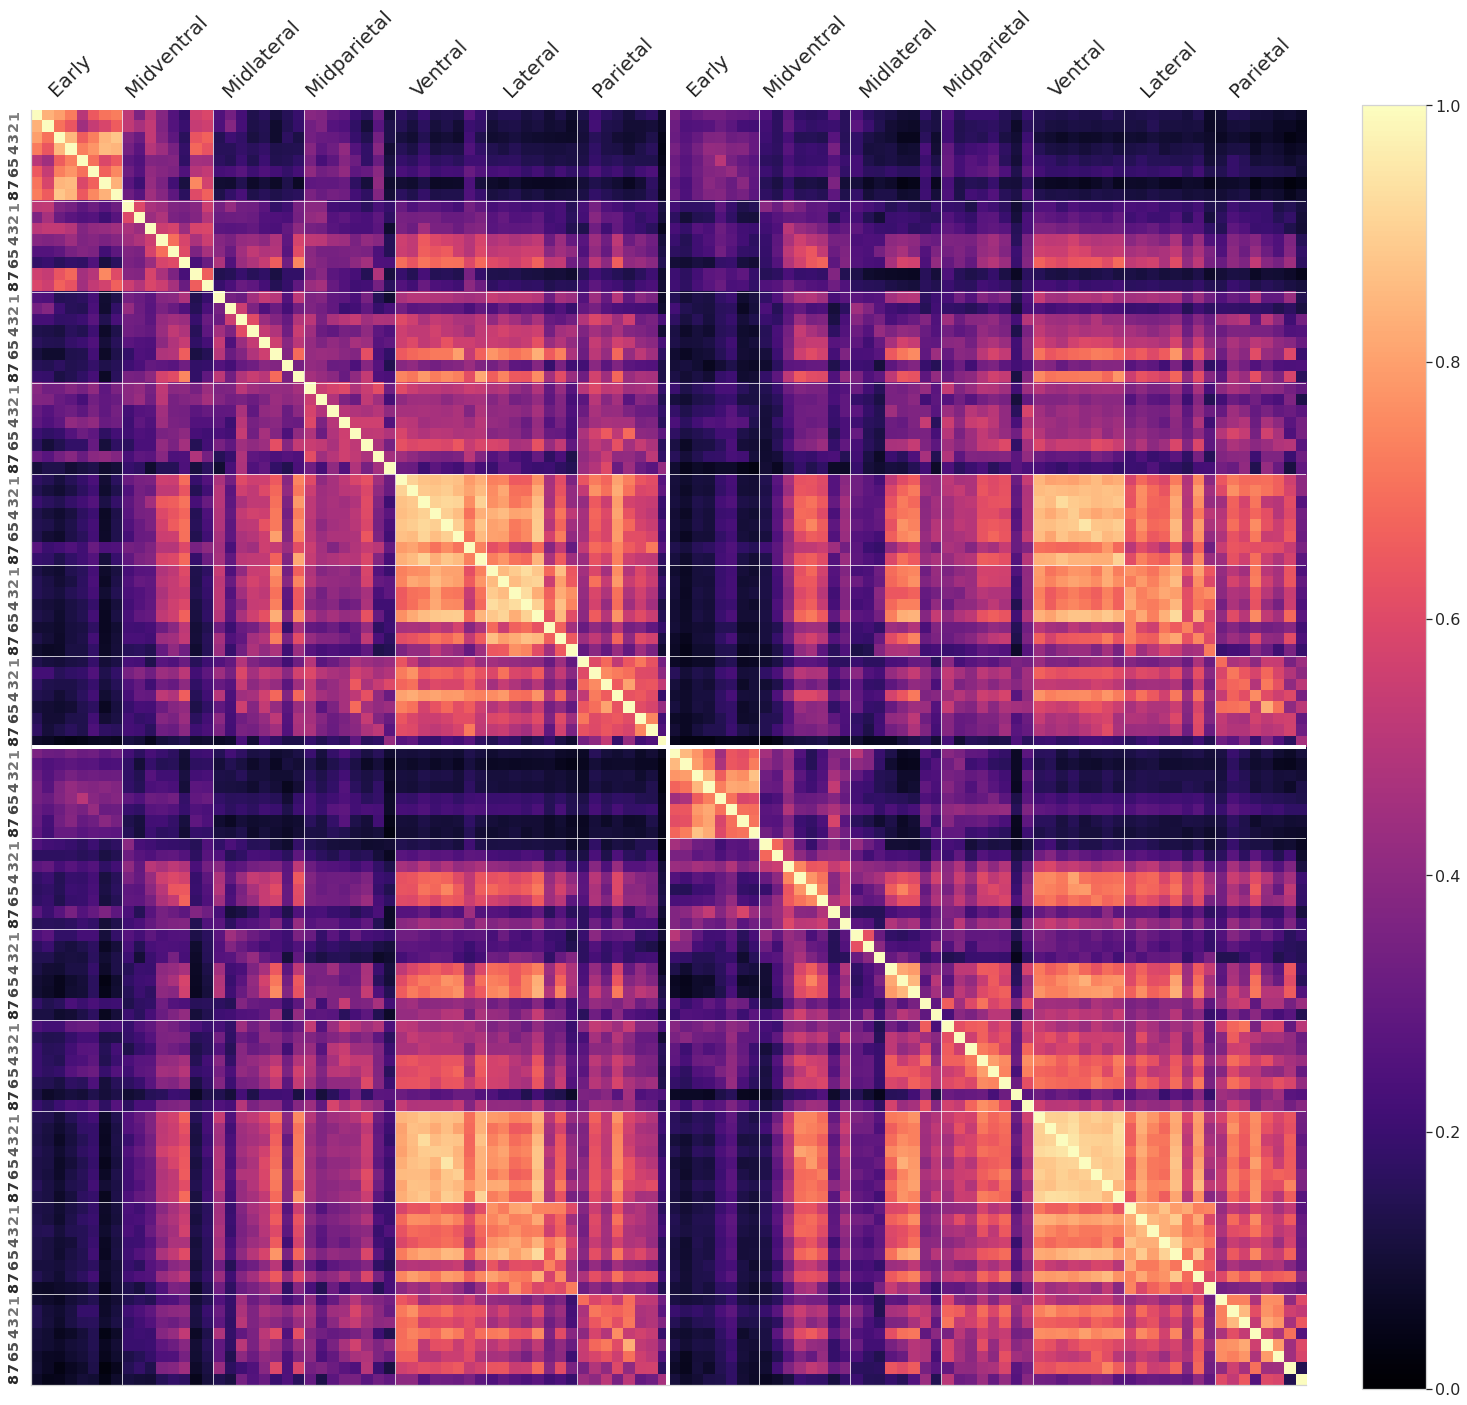

In [64]:
plt.figure(figsize=(25, 25))
plt.imshow(mega_matrix,
           cmap='magma')

y_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal',
            'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

xlocs = np.array([3,11.5,19.75,27.5,35.5,43.5,51.5])
x_ticks= np.concatenate((xlocs,xlocs+56))
plt.xticks(x_ticks, x_labels, fontsize=20, rotation = 45)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, total_combs)
plt.yticks(y_ticks, np.tile(y_labels, 2*7), fontsize='large', fontweight='extra bold', rotation = 90)
colors = ['#808080','#737373','#666666','#595959','#4d4d4d','#404040','#333333','#262626','#1a1a1a','#0d0d0d','#000000']
##66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(total_combs):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

for l in range(13):
    if l == 6:
        plt.axvline(x=7.5 + l*8, c='w',linewidth=4)
        plt.axhline(y=7.5 + l*8, c='w',linewidth=4)
    else:
        plt.axvline(x=7.5 + l*8, c='w',linewidth=0.75)
        plt.axhline(y=7.5 + l*8, c='w',linewidth=0.75)

plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_adjusted_both_noabs_wholebrain.png')
#plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_adjusted_both_noabs_wholebrain.svg')


In [11]:
mega_matrix.shape

(112, 112)

In [37]:
mega_MDS = MDS(dissimilarity='precomputed')
x, y = mega_MDS.fit_transform(1-mega_matrix).T

<IPython.core.display.Javascript object>


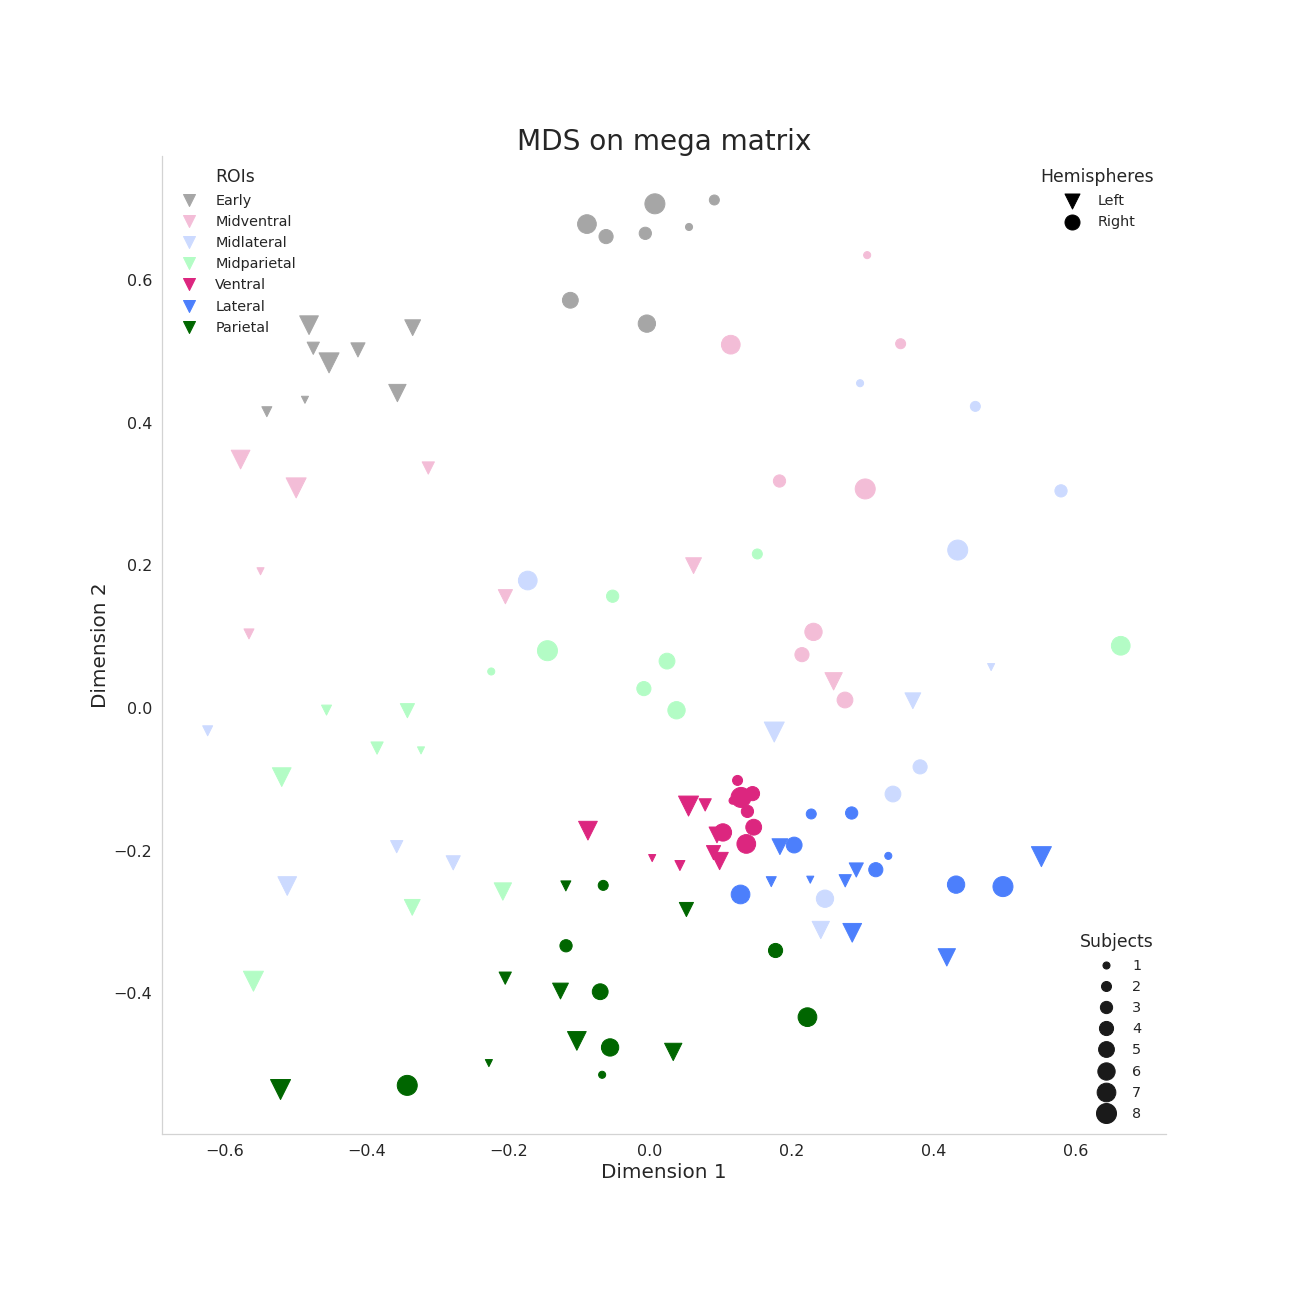

In [38]:
lh_x = x[0:int(len(x)/2)]
lh_y = y[0:int(len(x)/2)]

rh_x = x[int(len(x)/2):]
rh_y = y[int(len(x)/2):]

fig, ax = plt.subplots(figsize=(18, 18))

s = 50*np.array([[1,2,3,4,5,6,7,8]])
sizes = np.tile(s, 7)

c = np.array([[1,2,3,4,5,6,7]])
colors = np.repeat(c, 8)

rois =('Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal')

presets = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']

#presets = ['#999999' , '#ffad99', '#adebad', '#809fff', '#ff3300' ,'#2eb82e', '#0040ff']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("my_colormap",presets)

scatter = ax.scatter(lh_x, lh_y, s=sizes, c=colors, cmap=cmap, marker = "v") 
scatter2 = ax.scatter(rh_x, rh_y, s=sizes, c=colors, cmap=cmap) 

legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=rois, 
                     loc="upper left", title="ROIs", title_fontsize = 'xx-large', fontsize='x-large',
                     markerscale = 2, frameon=False)
ax.add_artist(legend1)

kw = dict(prop="sizes", num=8, color='k', fmt="{x:.0f}",
          func=lambda s: s/50)
legend2 = ax.legend(*scatter2.legend_elements(**kw),
                    loc="lower right", title="Subjects", title_fontsize = 'xx-large', 
                    fontsize='x-large', frameon=False)
ax.add_artist(legend2)

ax.legend(labels=['Left', 'Right'], title="Hemispheres", edgecolor = 'black',
          title_fontsize = 'xx-large', fontsize='x-large', frameon=False)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

ax.set_title('MDS on mega matrix', fontsize = 28)
ax.set_xlabel("Dimension 1", fontsize=20)
ax.set_ylabel("Dimension 2", fontsize=20)

plt.show()

#fig.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_whole_MDS_colorscheme3.png')
#fig.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_whole_MDS_colorscheme3.svg')

In [39]:
## Stress calcs (credit: https://stackoverflow.com/questions/36428205/stress-attribute-sklearn-manifold-mds-python)
data = 1-mega_matrix

# Coordinates of points in the plan (n_components=2)
points = mega_MDS.embedding_

## sklearn Stress
print("sklearn stress :")
print(mega_MDS.stress_)
print("")

## Manual calculus of sklearn stress
DE = euclidean_distances(points)
stress = 0.5 * np.sum((DE - data)**2)
print("Manual calculus of sklearn stress :")
print(stress)
print("")

## Kruskal's stress (or stress formula 1)
stress1 = np.sqrt(stress / (0.5 * np.sum(data**2)))
print("Kruskal's Stress :")
print("[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]")
print(stress1)
print("")

sklearn stress :
168.5831498717141

Manual calculus of sklearn stress :
168.56218385834794

Kruskal's Stress :
[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]
0.24908516672620354



In [40]:
## trying 3 components?

mega_MDS3 = MDS(dissimilarity='precomputed', n_components = 3)
x, y, z = mega_MDS3.fit_transform(1-mega_matrix).T


In [42]:
# Coordinates of points in the plan 
data = 1-mega_matrix
points = mega_MDS3.embedding_

## sklearn Stress
print("sklearn stress :")
print(mega_MDS3.stress_)
print("")

## Manual calculus of sklearn stress
DE = euclidean_distances(points)
stress = 0.5 * np.sum((DE - data)**2)
print("Manual calculus of sklearn stress :")
print(stress)
print("")

## Kruskal's stress (or stress formula 1)
stress1 = np.sqrt(stress / (0.5 * np.sum(data**2)))
print("Kruskal's Stress :")
print("[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]")
print(stress1)
print("")

sklearn stress :
73.61940460492997

Manual calculus of sklearn stress :
73.57743982094334

Kruskal's Stress :
[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]
0.16456600527926432



<IPython.core.display.Javascript object>


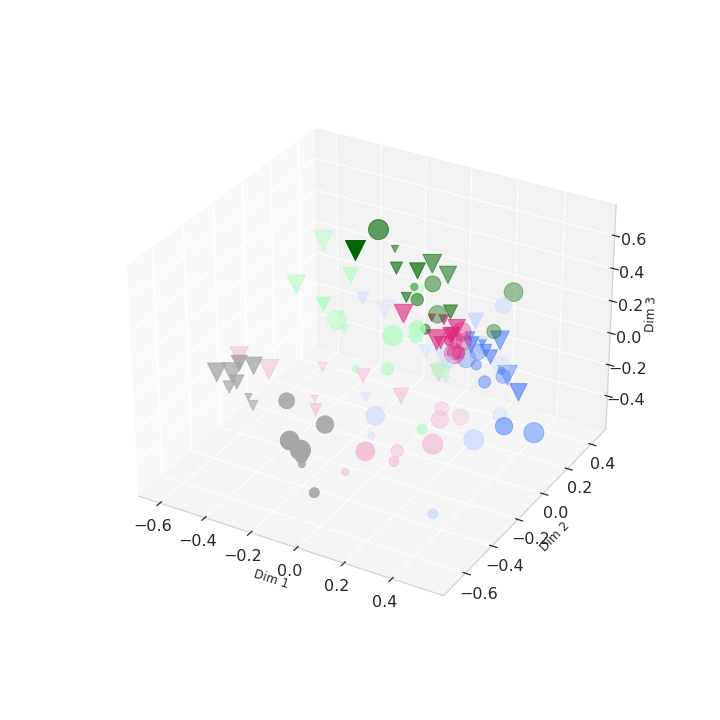

Text(0.5, 0, 'Dim 3')

In [44]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

lh_x = x[0:int(len(x)/2)]
lh_y = y[0:int(len(x)/2)]
lh_z = z[0:int(len(x)/2)]

rh_x = x[int(len(x)/2):]
rh_y = y[int(len(x)/2):]
rh_z = z[0:int(len(x)/2)]

s = 50*np.array([[1,2,3,4,5,6,7,8]])
sizes = np.tile(s, 7)

c = np.array([[1,2,3,4,5,6,7]])
colors = np.repeat(c, 8)

rois =('Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal')

presets = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("my_colormap",presets)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lh_x, lh_y, lh_z, s=sizes, c=colors, cmap=cmap, marker = "v")
ax.scatter(rh_x, rh_y, rh_z, s=sizes, c=colors, cmap=cmap)


ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

